In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
from datetime import datetime

In [2]:
import tools

In [3]:
data = pd.read_json("data/flink/pr-flat_20220602-13h35m41s_apache_flink_master_prs-brief.txt", lines=True)

In [4]:
tools.initialize_datetime(data)

In [5]:
data['hasRegularReviews'] = data['firstReviewCreatedAt'].notnull()
data['hasThreadedReview'] = data['firstReviewThreadCreatedAt'].notnull()
data['hasReviews'] = data['hasRegularReviews'] | data['hasThreadedReview']

In [6]:
data.head()

,title,state,number,createdAt,mergedAt,closedAt,labels,authorLogin,firstCommentCreatedAt,firstCommentPublishedAt,firstCommentAuthorLogin,firstReviewThreadCreatedAt,firstReviewThreadPublishedAt,firstReviewThreadAuthorLogin,firstReviewCreatedAt,firstReviewPublishedAt,firstReviewAuthorLogin,hasRegularReviews,hasThreadedReview,hasReviews
0,Fix for FLINK-708 and FLINK-887,CLOSED,1,2014-06-10 16:51:08+00:00,NaT,2014-06-10 19:42:14+00:00,[component=Deployment/YARN],rmetzger,2014-06-10 16:51:46+00:00,2014-06-10 16:51:46+00:00,rmetzger,NaT,NaT,None,NaT,NaT,None,False,False,False
1,ForwardFields Optimizer integration,CLOSED,2,2014-06-10 19:03:03+00:00,NaT,2014-07-29 13:47:17+00:00,[],skunert,2014-06-23 12:04:17+00:00,2014-06-23 12:04:17+00:00,skunert,2014-06-10 19:15:40+00:00,2014-06-10 19:15:40+00:00,rmetzger,NaT,NaT,None,False,True,True
2,"DistCache: executable flag, dir support",CLOSED,3,2014-06-10 19:22:44+00:00,NaT,2014-06-13 15:56:08+00:00,[],zentol,2014-06-13 10:52:21+00:00,2014-06-13 10:52:21+00:00,StephanEwen,2014-06-10 20:28:38+00:00,2014-06-10 20:28:38+00:00,rmetzger,NaT,NaT,None,False,True,True
3,"Serialized String comparison, Unicode support",CLOSED,4,2014-06-10 19:29:20+00:00,NaT,2015-08-27 12:05:32+00:00,[],zentol,2014-06-12 08:16:26+00:00,2014-06-12 08:16:26+00:00,zentol,NaT,NaT,None,NaT,NaT,None,False,False,False
4,[FLINK-917] Rename netty IO thread count param...,CLOSED,5,2014-06-10 22:31:31+00:00,NaT,2014-06-17 22:19:18+00:00,[component=Runtime/Network],uce,2014-06-12 13:41:42+00:00,2014-06-12 13:41:42+00:00,StephanEwen,NaT,NaT,None,NaT,NaT,None,False,False,False


In [7]:
n = data.shape[0]
max_pr = data['number'].max()

In [8]:
data = data.set_index('createdAt')
data['createdAt'] = data.index

In [9]:
data['_count'] = 1
data['totalCount'] = data['_count'].cumsum()

## Number of Reviews

In [10]:
temp = (data['hasReviews'].value_counts() / n * 100)
perc_has_review = temp.loc[True]
perc_has_no_review = temp.loc[False]

print(f"Only {perc_has_review:2.2f} % of all PRs have a review")

Only 66.42 % of all PRs have a review


In [11]:
data['reviewCount'] = (data['hasReviews']*1).cumsum()
data['diffCount'] = data['totalCount'] - data['reviewCount']

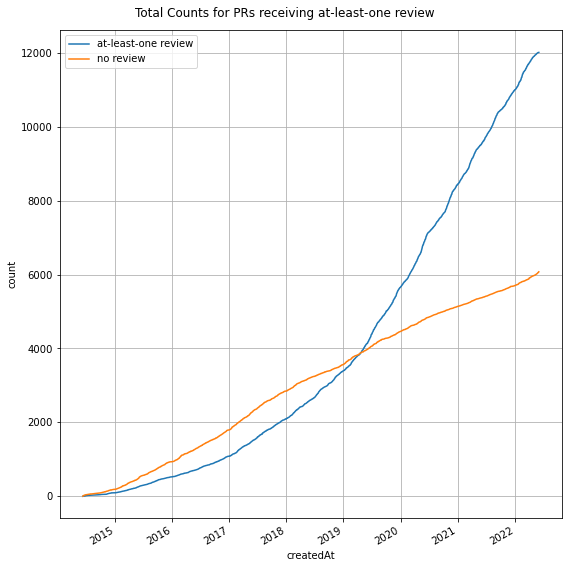

In [12]:
f, ax = plt.subplots(figsize=(8, 8))
data[['reviewCount', 'diffCount']].plot(ax=ax)
ax.set(ylabel='count')
ax.legend(["at-least-one review", "no review"])
ax.grid(which='both')
f.suptitle('Total Counts for PRs receiving at-least-one review')
tools.savefig(f, 'prs_at_least_one_review_counts')

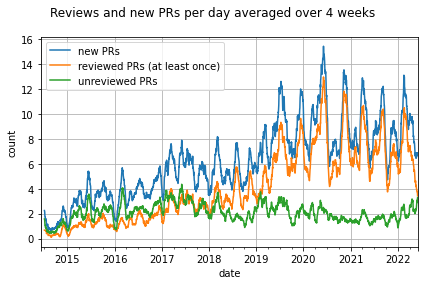

In [13]:
f, ax = plt.subplots()
new_prs_per_day = (data['_count']).resample('D').sum()
new_prs_per_day.rolling(28).mean().plot(ax=ax, label='new PRs')
reviewed_prs_per_day = (data['hasReviews']*1).resample('D').sum()
reviewed_prs_per_day.rolling(28).mean().plot(ax=ax, label='reviewed PRs (at least once)')
diff = new_prs_per_day - reviewed_prs_per_day
diff.rolling(28).mean().plot(ax=ax, label='unreviewed PRs')
f.suptitle("Reviews and new PRs per day averaged over 4 weeks")
ax.set(xlabel='date', ylabel='count')
ax.grid()
ax.legend()
tools.savefig(f, 'prs_daily_reviews_and_new_prs')

Could the reason be that we are not reviewing some PRs at all? No, even though the number of created PRs is on the rise, we see in the figure below that the number of completely unreviewed PRs is at a low constant factor of about 2 per month.

## Time to first review

In [14]:
data.loc[data['hasReviews']].shape[0]

12016

In [15]:
data.loc[~data['hasReviews']].shape[0]

6075

In [16]:
def cdf_ser(series: pd.Series) -> pd.Series:
    count = series.value_counts().sort_index()
    perc = count / count.sum() * 100
    return perc.cumsum()

We need to figure out the minimum timestamp

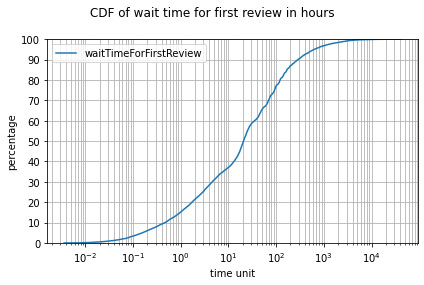

In [17]:
subset = data.loc[data['hasRegularReviews']].copy()
subset['firstReviewCreatedAt'] = pd.to_datetime(subset['firstReviewCreatedAt'])
subset['waitTimeForFirstReview'] = subset['firstReviewCreatedAt'] - subset['createdAt'] 
wait_time_in_hours = subset['waitTimeForFirstReview'].dt.total_seconds()/(60*60)
f, ax = plt.subplots()
cdf_ser(wait_time_in_hours.sort_values()).plot(ax=ax)
ax.legend()
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.set(xscale='log', xlabel='time unit', ylabel='percentage', ylim=(0, 100))
ax.grid(which='both')
f.suptitle('CDF of wait time for first review in hours')
tools.savefig(f, 'prs_cdf_wait_time_for_first_review_in_hours')

/var/folders/m2/_1_4fj9d5554nslmpq2n_bq00000gn/T/ipykernel_20422/397027268.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  wait_time_in_hours.sort_index().loc[datetime(2017, 1, 1):datetime(2022, 1, 3)].groupby(pd.Grouper(freq='M')).mean().plot(ax=ax)


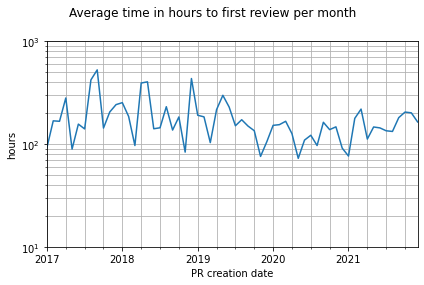

In [18]:
f, ax = plt.subplots()
wait_time_in_hours.sort_index().loc[datetime(2017, 1, 1):datetime(2022, 1, 3)].groupby(pd.Grouper(freq='M')).mean().plot(ax=ax)
ax.set(yscale='log', xlabel='PR creation date', ylabel='hours', ylim=(10, 1000))
ax.grid(which='both')
f.suptitle('Average time in hours to first review per month')
tools.savefig(f, 'prs_monthly_wait_time_for_first_review_in_hours')

In [19]:
print(f"Average wait time of {wait_time_in_hours.mean() / 24: 2.1f} days to first review")

Average wait time of  7.1 days to first review


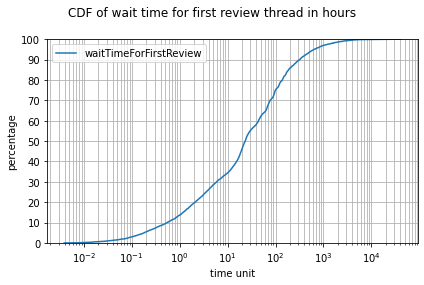

In [20]:
subset = data.loc[data['hasThreadedReview']].copy()
subset['firstReviewThreadCreatedAt'] = pd.to_datetime(subset['firstReviewThreadCreatedAt'])
subset['waitTimeForFirstReview'] = subset['firstReviewThreadCreatedAt'] - subset['createdAt'] 
wait_time_in_hours = subset['waitTimeForFirstReview'].dt.total_seconds()/(60*60)
f, ax = plt.subplots()
cdf_ser(wait_time_in_hours.sort_values()).plot(ax=ax)
ax.legend()
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.set(xscale='log', xlabel='time unit', ylabel='percentage', ylim=(0, 100))
ax.grid(which='both')
f.suptitle('CDF of wait time for first review thread in hours')
tools.savefig(f, 'prs_cdf_wait_time_for_first_review_thread_in_hours')

/var/folders/m2/_1_4fj9d5554nslmpq2n_bq00000gn/T/ipykernel_20422/2378782596.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  wait_time_in_hours.sort_index().loc[datetime(2017, 1, 1):datetime(2022, 1, 3)].groupby(pd.Grouper(freq='M')).mean().plot(ax=ax)


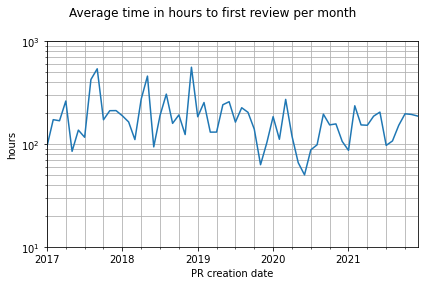

In [21]:
f, ax = plt.subplots()
wait_time_in_hours.sort_index().loc[datetime(2017, 1, 1):datetime(2022, 1, 3)].groupby(pd.Grouper(freq='M')).mean().plot(ax=ax)
ax.set(yscale='log', xlabel='PR creation date', ylabel='hours', ylim=(10, 1000))
ax.grid(which='both')
f.suptitle('Average time in hours to first review per month')
tools.savefig(f, 'prs_monthly_wait_time_for_first_review_thread_in_hours')

In [22]:
print(f"Average wait time of {wait_time_in_hours.mean() / 24: 2.1f} days to first review")

Average wait time of  7.0 days to first review
